In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import matplotlib
from numpy import inf
from scipy import stats
import scipy as sp

matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline
plt.rcParams['font.family'] = 'Malgun Gothic'

## 1. 코로나 확진자수 데이터 (중구, 노원구)

In [2]:
# http://data.seoul.go.kr/dataList/OA-20279/S/1/datasetView.do;jsessionid=D7167DD1052B37210BE999351939C602.new_portal-svr-21
seoul_corona_orig = pd.read_csv("data/서울시 코로나19 확진자 현황.csv", encoding='utf-8')

In [3]:
seoul_corona_orig.head()

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
0,3773,8.29.,19546,NaN,NaN,기타,NaN,확인 중,NaN,NaN,확인 중,2020-08-31 9:44,2020-08-31 9:44,Y
1,3772,8.29.,19533,NaN,NaN,기타,NaN,확인 중,NaN,NaN,확인 중,2020-08-31 9:44,2020-08-31 9:44,Y
2,3771,8.29.,19446,NaN,NaN,기타,NaN,확인 중,NaN,NaN,확인 중,2020-08-31 9:44,2020-08-31 9:44,Y
3,3770,8.29.,19484,NaN,NaN,기타,NaN,확인 중,NaN,NaN,확인 중,2020-08-31 9:44,2020-08-31 9:44,Y
4,3769,8.29.,19596,NaN,NaN,기타,NaN,확인 중,NaN,NaN,확인 중,2020-08-31 9:44,2020-08-31 9:44,Y


In [4]:
seoul_gu = ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
            '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', 
            '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구']
seoul_corona = seoul_corona_orig.query(f'지역 in {seoul_gu}') # 서울 외 다른 지역 제거

In [5]:
seoul_corona = seoul_corona.pivot_table(values='환자번호', index='확진일', columns='지역', aggfunc='count').reset_index()
seoul_corona.fillna(0, inplace=True)
seoul_corona['합'] = seoul_corona.drop('확진일', axis=1).sum(axis=1) # 서울 일별 확진자수 

In [6]:
seoul_corona['확진일'] = seoul_corona['확진일'].apply(lambda x:"2020."+x)
seoul_corona['확진일'] = pd.to_datetime(seoul_corona['확진일'], format='%Y.%m.%d.')

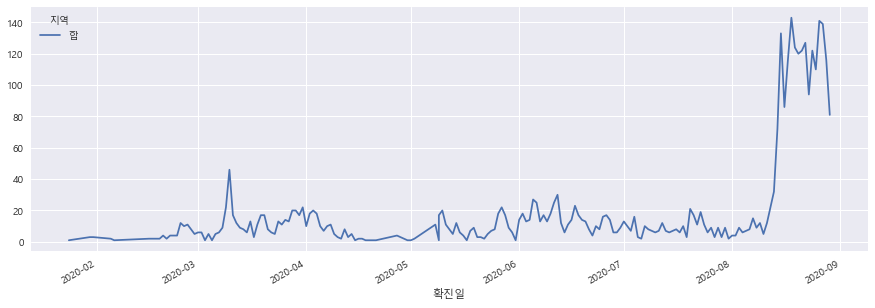

In [7]:
# 서울 일별 신규확진자수 시각화
seoul_corona.set_index('확진일')[['합']].plot(figsize=(15, 5))

In [8]:
junggu_corona = seoul_corona[['확진일', '중구']]
nowon_corona = seoul_corona[['확진일', '노원구']]

## 2. 유동인구 / 생활인구 데이터 로드

In [9]:
temp = pd.read_csv("data/02_카드매출데이터(신한카드)/CARD_SPENDING_RESIDENT/CARD_SPENDING_RESIDENT_KOR.csv")
dong_to_gu = {}
for gu, dong in temp[['GU_CD', 'DONG_CD']].values:
    dong_to_gu[dong] = gu

In [10]:
# 유동인구
# load data
floating_pop_201902 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201902.csv", sep='|')
floating_pop_201903 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201903.csv", sep='|')
floating_pop_201904 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201904.csv", sep='|')
floating_pop_201905 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201905.csv", sep='|')
floating_pop_202002 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202002.csv", sep='|')
floating_pop_202003 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202003.csv", sep='|')
floating_pop_202004 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202004.csv", sep='|')
floating_pop_202005 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202005.csv", sep='|')
floating_pop = pd.concat([floating_pop_201902, floating_pop_201903, floating_pop_201904, floating_pop_201905, floating_pop_202002, floating_pop_202003, floating_pop_202004, floating_pop_202005], axis=0)

# melt
floating_pop = pd.melt( floating_pop, 
                id_vars=['STD_YM', 'STD_YMD', 'HDONG_CD', 'HDONG_NM'], 
                value_vars=floating_pop.columns[4:].tolist())
floating_pop.rename(columns={"value":"floating_pop"}, inplace=True)

# 성별 추출 + 연령 추출
sex_dict = {"MAN":"M", "WMAN":"F"}
floating_pop['SEX_CD'] = floating_pop['variable'].apply(lambda x:sex_dict[x.split('_')[0]])
floating_pop['AGE_CD'] = floating_pop['variable'].apply(lambda x:x.split('_')[-1][:4])

# 날짜처리
weekdays = {0:'월', 1:'화', 2:'수', 3:'목', 4:'금', 5:'토', 6:'일'}
floating_pop['STD_YMD'] = pd.to_datetime(floating_pop.STD_YMD, format='%Y%m%d')
floating_pop['YEAR'] = floating_pop.STD_YMD.dt.year
floating_pop['MONTH'] = floating_pop.STD_YMD.dt.month
floating_pop['WEEK_NUM'] = floating_pop.STD_YMD.dt.weekofyear
floating_pop['WEEKDAY'] = floating_pop.STD_YMD.dt.dayofweek.apply(lambda x : '_'.join([str(x),weekdays.get(x)]))

# 재정렬
floating_pop = floating_pop[['STD_YMD', 'STD_YM', 'YEAR', 'MONTH', 'WEEK_NUM', 'WEEKDAY', 'HDONG_NM', 'SEX_CD', 'AGE_CD', 'floating_pop']]

In [11]:
floating_pop['GU'] = floating_pop['HDONG_NM'].apply(lambda x:dong_to_gu[x])
floating_pop = floating_pop.query('GU in ["서울 중구", "서울 노원구"]') # 서울 데이터만 추출

In [12]:
living_pop = pd.read_csv("local_people_data.csv")

# melt
living_pop = pd.melt( living_pop, 
                               id_vars=['STD_DD', '시간대구분', 'G_DNG_NM'], 
                               value_vars=['남자_0009세생활인구수', '남자_1014세생활인구수', '남자_1519세생활인구수', 
                                           '남자_2024세생활인구수', '남자_2529세생활인구수', '남자_3034세생활인구수',
                                           '남자_3539세생활인구수', '남자_4044세생활인구수', '남자_4549세생활인구수', 
                                           '남자_5054세생활인구수', '남자_5559세생활인구수', '남자_6064세생활인구수', 
                                           '남자_6569세생활인구수', '남자_70세이상생활인구수',
                                           '여자_0009세생활인구수', '여자_1014세생활인구수', '여자_1519세생활인구수', 
                                           '여자_2024세생활인구수', '여자_2529세생활인구수', '여자_3034세생활인구수', 
                                           '여자_3539세생활인구수', '여자_4044세생활인구수', '여자_4549세생활인구수', 
                                           '여자_5054세생활인구수', '여자_5559세생활인구수', '여자_6064세생활인구수',
                                           '여자_6569세생활인구수', '여자_70세이상생활인구수'])
living_pop.rename(columns={"value":"FLOW"}, inplace=True)

# 성별 추출 + 연령 추출
sex_dict = {"남자":"M", "여자":"F"}
living_pop['SEX_CD'] = living_pop['variable'].apply(lambda x:sex_dict[x.split('_')[0]])
living_pop['AGE_CD'] = living_pop['variable'].apply(lambda x:(x.split('_')[-1][:4]))
living_pop['AGE_CD'] = living_pop['AGE_CD'].replace('70세이', '70U')

# 날짜처리
weekdays = {0:'월', 1:'화', 2:'수', 3:'목', 4:'금', 5:'토', 6:'일'}
living_pop['STD_DD'] = pd.to_datetime(living_pop.STD_DD, format='%Y-%m-%d')
living_pop['YEAR'] = living_pop.STD_DD.dt.year
living_pop['MONTH'] = living_pop.STD_DD.dt.month
living_pop['WEEK_NUM'] = living_pop.STD_DD.dt.weekofyear
living_pop['WEEKDAY'] = living_pop.STD_DD.dt.dayofweek.apply(lambda x : '_'.join([str(x),weekdays.get(x)]))

# 재정렬
living_pop = living_pop[['STD_DD', 'YEAR', 'MONTH', 'WEEK_NUM', 'WEEKDAY', '시간대구분', 'G_DNG_NM', 'SEX_CD', 'AGE_CD', 'FLOW']]

In [13]:
living_pop['GU'] = living_pop['G_DNG_NM'].apply(lambda x:" ".join([x.split()[0], x.split()[1]]))
living_pop['DONG'] = living_pop['G_DNG_NM'].apply(lambda x:x.split()[-1])

In [14]:
floating_pop.head()

,STD_YMD,STD_YM,YEAR,MONTH,WEEK_NUM,WEEKDAY,HDONG_NM,SEX_CD,AGE_CD,floating_pop,GU
0,2019-02-01,201902,2019,2,5,4_금,소공동,M,0004,16.64,서울 중구
1,2019-02-02,201902,2019,2,5,5_토,소공동,M,0004,3.14,서울 중구
2,2019-02-03,201902,2019,2,5,6_일,소공동,M,0004,1.38,서울 중구
3,2019-02-04,201902,2019,2,6,0_월,소공동,M,0004,0.08,서울 중구
4,2019-02-05,201902,2019,2,6,1_화,소공동,M,0004,0.00,서울 중구


In [15]:
living_pop.head()

,STD_DD,YEAR,MONTH,WEEK_NUM,WEEKDAY,시간대구분,G_DNG_NM,SEX_CD,AGE_CD,FLOW,GU,DONG
0,2019-02-01,2019,2,5,4_금,0,서울 노원구 중계2.3동,M,0009,1858.3096,서울 노원구,중계2.3동
1,2019-02-01,2019,2,5,4_금,1,서울 노원구 중계2.3동,M,0009,1785.0549,서울 노원구,중계2.3동
2,2019-02-01,2019,2,5,4_금,2,서울 노원구 중계2.3동,M,0009,1733.5305,서울 노원구,중계2.3동
3,2019-02-01,2019,2,5,4_금,3,서울 노원구 중계2.3동,M,0009,1745.2137,서울 노원구,중계2.3동
4,2019-02-01,2019,2,5,4_금,4,서울 노원구 중계2.3동,M,0009,1712.3663,서울 노원구,중계2.3동


## 3. 확진자수& 유동인구/생활인구 상관계수

In [16]:
floating_pop['STD_YMD'] = pd.to_datetime(floating_pop['STD_YMD'], format='%Y-%m-%d')
living_pop['STD_DD'] = pd.to_datetime(living_pop['STD_DD'], format='%Y-%m-%d')

In [17]:
nowon_floating = floating_pop.query('(YEAR==2020) and (GU=="서울 노원구")')
junggu_floating = floating_pop.query('(YEAR==2020) and (GU=="서울 중구")')

nowon_living = living_pop.query('(YEAR==2020) and (GU=="서울 노원구") and (8<=시간대구분<=22)')
junggu_living = living_pop.query('(YEAR==2020) and (GU=="서울 중구") and (8<=시간대구분<=22)')

In [18]:
nowon_floating = nowon_floating.groupby(['STD_YMD'])[['floating_pop']].sum().reset_index()
junggu_floating = junggu_floating.groupby(['STD_YMD'])[['floating_pop']].sum().reset_index()

In [19]:
nowon_living = nowon_living.groupby(['STD_DD', '시간대구분'])[['FLOW']].sum().reset_index()
nowon_living = nowon_living.groupby(['STD_DD'])[['FLOW']].mean().reset_index()

junggu_living = junggu_living.groupby(['STD_DD', '시간대구분'])[['FLOW']].sum().reset_index()
junggu_living = junggu_living.groupby(['STD_DD'])[['FLOW']].mean().reset_index()

In [60]:
nowon = pd.merge(seoul_corona[['확진일', '합', '노원구']], nowon_floating, 
                 left_on='확진일', right_on='STD_YMD', how='right')
nowon = pd.merge(nowon, nowon_living, left_on='STD_YMD', right_on='STD_DD', how='left')

In [61]:
nowon.sort_values(by='STD_DD', inplace=True)
nowon = nowon[['STD_DD', '노원구', '합', 'floating_pop', 'FLOW']]
nowon.rename(columns={"floating_pop":"floating", 'FLOW':'living'}, inplace=True)
nowon['노원구_shift1'] = nowon['노원구'].shift(1)
nowon.fillna(0, inplace=True)

In [68]:
junggu = pd.merge(seoul_corona[['확진일', '합', '중구']], junggu_floating, 
                 left_on='확진일', right_on='STD_YMD', how='right')
junggu = pd.merge(junggu, junggu_living, left_on='STD_YMD', right_on='STD_DD', how='left')

In [69]:
junggu.sort_values(by='STD_DD', inplace=True)
junggu = junggu[['STD_DD', '중구', '합', 'floating_pop', 'FLOW']]
junggu.rename(columns={"floating_pop":"floating", 'FLOW':'living'}, inplace=True)
junggu['중구_shift1'] = junggu['중구'].shift(1)
junggu.fillna(0, inplace=True)

In [70]:
nowon[['노원구', '노원구_shift1', '합', 'floating', 'living']].corr()

,노원구,노원구_shift1,합,floating,living
노원구,1.000000,0.360989,0.399568,-0.130730,-0.083951
노원구_shift1,0.360989,1.000000,0.343551,-0.173708,0.055238
합,0.399568,0.343551,1.000000,-0.119450,-0.077758
floating,-0.130730,-0.173708,-0.119450,1.000000,-0.705000
living,-0.083951,0.055238,-0.077758,-0.705000,1.000000


In [71]:
junggu[['중구', '중구_shift1', '합', 'floating', 'living']].corr()

,중구,중구_shift1,합,floating,living
중구,1.000000,0.160275,0.342325,0.105449,0.111861
중구_shift1,0.160275,1.000000,0.407337,-0.087672,-0.078505
합,0.342325,0.407337,1.000000,-0.037924,0.044794
floating,0.105449,-0.087672,-0.037924,1.000000,0.970354
living,0.111861,-0.078505,0.044794,0.970354,1.000000


**상관관계 없어보인다 왜 그럴까?** -> 구 일별 확진자수 매우 적다

Text(0.5, 1.0, '생활인구')

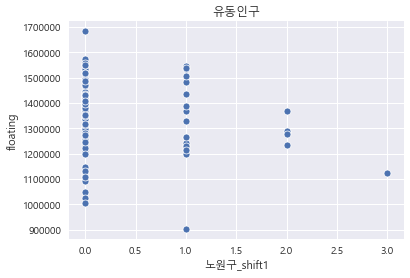

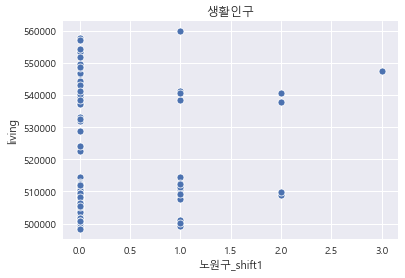

In [72]:
plt.figure()
sns.scatterplot(x='노원구_shift1', y='floating', data=nowon)
plt.title("유동인구")

plt.figure()
sns.scatterplot(x='노원구_shift1', y='living', data=nowon)
plt.title("생활인구")

Text(0.5, 1.0, '생활인구')

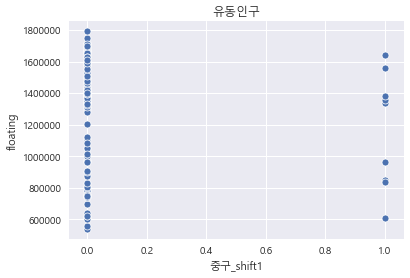

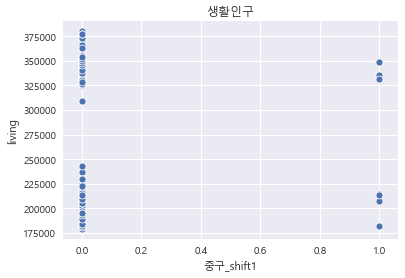

In [73]:
plt.figure()
sns.scatterplot(x='중구_shift1', y='floating', data=junggu)
plt.title("유동인구")

plt.figure()
sns.scatterplot(x='중구_shift1', y='living', data=junggu)
plt.title("생활인구")

## 4. 일별 코로나 위험지수 -> ?
- 전체적인 확진자 수 추이를 어떻게 반영할 것인지
- 확진자 수 0명일 때는?
- 동별 확진자수 / 전체 확진자수
<br><br>
- 생활인구 예측
    1. 교통량
        - https://data.seoul.go.kr/dataList/OA-12914/S/1/datasetView.do
        - https://data.seoul.go.kr/dataList/OA-12252/S/1/datasetView.do
    2. 평일/주말 분리 -> 노원구의 경우 토/일 생활인구 많고, 중구의 경우 월~금 생활인구가 많다
    3. 코로나의 영향력 (코로나 위험 지수)

Text(0.5, 1.0, '노원구 : 노원구 확진자수와 생활인구')

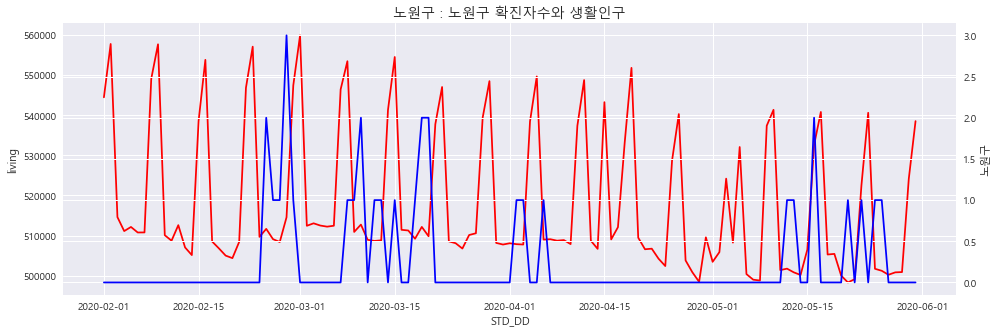

In [74]:
plt.figure(figsize=(16, 5))
ax = sns.lineplot(x='STD_DD', y='living', data=nowon, color='red')
ax_twinx = ax.twinx()
sns.lineplot(x='STD_DD', y='노원구', data=nowon, ax=ax_twinx, color='blue')
ax.set_title("노원구 : 노원구 확진자수와 생활인구", size=14)

Text(0.5, 1.0, '노원구 : 서울 확진자수와 생활인구')

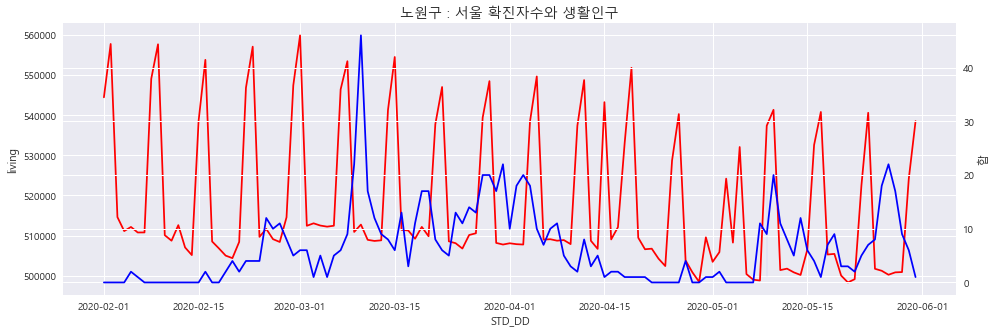

In [75]:
plt.figure(figsize=(16, 5))
ax = sns.lineplot(x='STD_DD', y='living', data=nowon, color='red')
ax_twinx = ax.twinx()
sns.lineplot(x='STD_DD', y='합', data=nowon, ax=ax_twinx, color='blue')
ax.set_title("노원구 : 서울 확진자수와 생활인구", size=14)

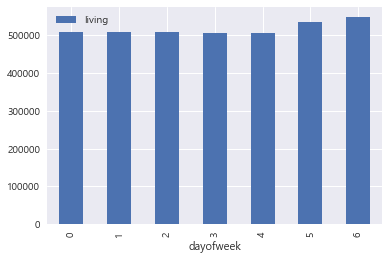

In [99]:
nowon_temp = nowon.copy()
nowon_temp['dayofweek'] = nowon['STD_DD'].dt.dayofweek
nowon_temp.groupby(['dayofweek'])[['living']].mean().plot(kind='bar')

In [76]:
from statsmodels.tsa.seasonal import seasonal_decompose

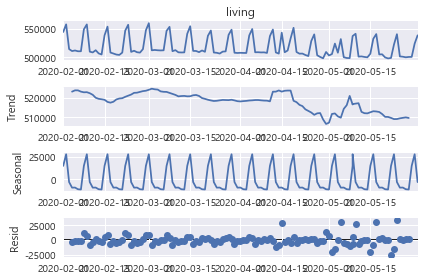

In [88]:
# 노원구 생활인구 
nowon_seasonal_decompose = seasonal_decompose(x=nowon.set_index('STD_DD')['living'], period=7, model='additive')
nowon_seasonal_decompose.plot();

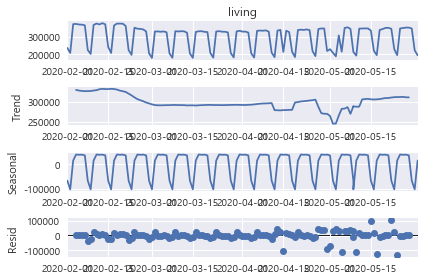

In [89]:
# 중구 생활인구
junggu_seasonal_decompose = seasonal_decompose(x=junggu.set_index('STD_DD')['living'], period=7, model='additive')
junggu_seasonal_decompose.plot();

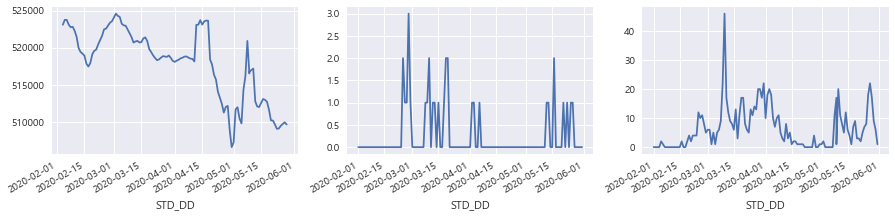

In [95]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 3))
nowon_seasonal_decompose.trend.plot(ax=axes[0])
nowon.set_index('STD_DD')['노원구'].plot(ax=axes[1])
nowon.set_index('STD_DD')['합'].plot(ax=axes[2])

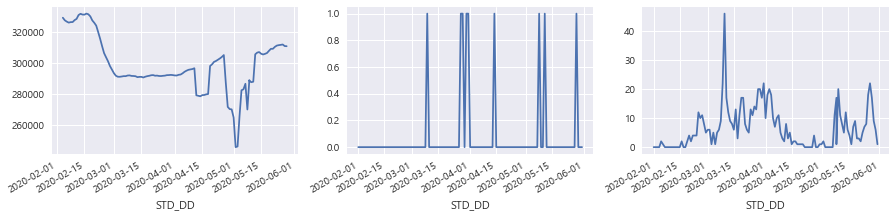

In [96]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 3))
junggu_seasonal_decompose.trend.plot(ax=axes[0])
junggu.set_index('STD_DD')['중구'].plot(ax=axes[1])
junggu.set_index('STD_DD')['합'].plot(ax=axes[2])

**5월초에 trend에서 갑자기 벗어난다**

In [111]:
nowon_seasonal_decompose.trend.idxmin() # 부처님오신날

# 노원구에서 부처님오신날 생활인구 trend 급감 -> 놀러갔다 .. ?

Timestamp('2020-04-30 00:00:00')

In [110]:
junggu_seasonal_decompose.trend.idxmin() # 4월 30일 부처님오신날 / 5월 1일 근로자의 날 / 5월 2일 토요일

# 중구에서 5월 2일 생활인구 trend 급감

Timestamp('2020-05-02 00:00:00')

In [106]:
temp = pd.merge(junggu_seasonal_decompose.trend.reset_index(), junggu[['STD_DD', '합']], on='STD_DD').dropna()
np.corrcoef(x=temp.trend, y=temp.합)

array([[ 1.        , -0.16877724],
       [-0.16877724,  1.        ]])

In [107]:
temp = pd.merge(nowon_seasonal_decompose.trend.reset_index(), nowon[['STD_DD', '합']], on='STD_DD').dropna()
np.corrcoef(x=temp.trend, y=temp.합)

array([[1.        , 0.07066903],
       [0.07066903, 1.        ]])

In [137]:
def living_pop_2019_2020(gu_name):
    df_2019 = living_pop.query(f'(YEAR==2019) & (GU=="{gu_name}") & (8<=시간대구분<=22)')
    df_2019 = df_2019.groupby(['STD_DD', '시간대구분'])['FLOW'].sum().reset_index()
    df_2019 = df_2019.groupby(['STD_DD'])['FLOW'].mean()
    df_2019.sort_index(inplace=True)
    
    df_2020 = living_pop.query(f'(YEAR==2020) & (GU=="{gu_name}") & (8<=시간대구분<=22)')
    df_2020 = df_2020.groupby(['STD_DD', '시간대구분'])['FLOW'].sum().reset_index()
    df_2020 = df_2020.groupby(['STD_DD'])['FLOW'].mean()
    df_2020.sort_index(inplace=True)    
    
    return [df_2019, df_2020]

In [139]:
junggu_2019, junggu_2020 = living_pop_2019_2020("서울 중구")

In [138]:
nowon_2019, nowon_2020 = living_pop_2019_2020("서울 노원구")

Text(0.5, 1.0, '2020년 중구')

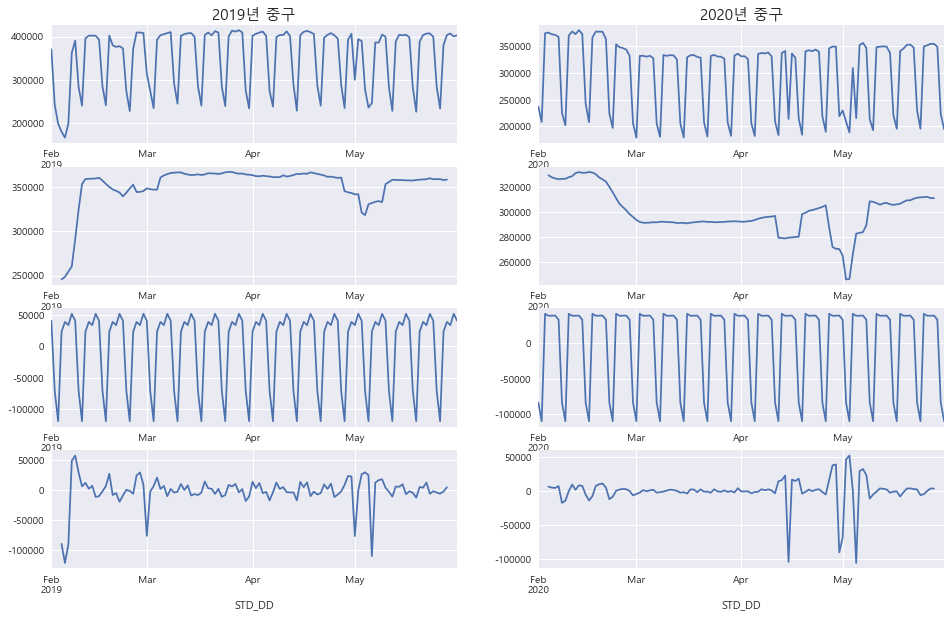

In [155]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 10))
result1 = seasonal_decompose(junggu_2019)
result2 = seasonal_decompose(junggu_2020)

result1.observed.plot(ax=axes[0][0])
result2.observed.plot(ax=axes[0][1])
result1.trend.plot(ax=axes[1][0])
result2.trend.plot(ax=axes[1][1])
result1.seasonal.plot(ax=axes[2][0])
result2.seasonal.plot(ax=axes[2][1])
result1.resid.plot(ax=axes[3][0])
result2.resid.plot(ax=axes[3][1])

axes[0][0].set_title("2019년 중구", size=15)
axes[0][1].set_title("2020년 중구", size=15)

Text(0.5, 1.0, '2020년 노원구')

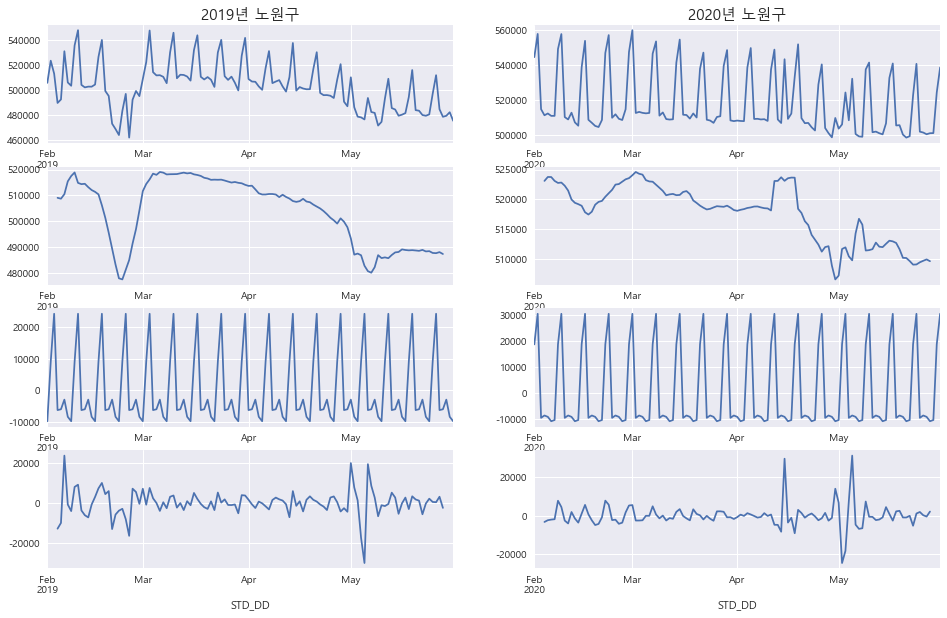

In [156]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 10))
result1 = seasonal_decompose(nowon_2019)
result2 = seasonal_decompose(nowon_2020)

result1.observed.plot(ax=axes[0][0])
result2.observed.plot(ax=axes[0][1])
result1.trend.plot(ax=axes[1][0])
result2.trend.plot(ax=axes[1][1])
result1.seasonal.plot(ax=axes[2][0])
result2.seasonal.plot(ax=axes[2][1])
result1.resid.plot(ax=axes[3][0])
result2.resid.plot(ax=axes[3][1])

axes[0][0].set_title("2019년 노원구", size=15)
axes[0][1].set_title("2020년 노원구", size=15)